# Project DeepChef

## Food.com - Recipes and Reviews
### Data on over 500,000 recipes and 1,400,000 reviews from Food.com
Link to the dataset: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews

## Data Processing and Cleaning - TO DO LIST

### 1. Upgrade the recipes dataset with accurate ingredients info:
Many of the recipes suffer from one of the following: inaccurate ingredient-quants lists (e.g., from '1 1/2 cans of beans', 1 and 1/2 have been separated), inaccurate ingred-items lists (e.g., '2 spoons of butter or margrine' both butter and margrine have been sepearated and added to the relevant list). As a result of such mistakes, many mismatches occur between ingred_quants and ingred_items. Also measures are missing (lbs, teaspoon, cans, etc), so it's not clear what those quantities are measured with. Run the following codes to see an example: 

                        print('https://www.food.com/recipe/crunchy-peanut-biscuit-ring-18289')
                        print(recipes.iloc[14987]['RecipeIngredientQuantities'])
                        print(recipes.iloc[14987]['RecipeIngredientParts'])
I'm goling to fix these problems by following the procedures below:

- Scrape all the links and recipe ids by making Selemnium scroll through food.com/search as much as it takes.
- Loop through all links and extract original `ingredient_quants` and `ingredient_items` from the page (maybe also other things such as `picked_by`).
- Create a dataframe containing `link`, `RecipeID`, etc., and joing it with the Recipes dataset on `RecipeID`
- Drop the original `ingredient_quants` and `ingredient_items` from the Recipes dataset.
- <span style="color:red">**NOTE (June 18):**</span> This is being done in another Jupyter Notebook named `Scraping Food.com`.

### 2. Deal with null values and duplicates
<span style="color:red">**NOTE (June 19):**</span>
- [Several redundant columns were dropped andseveral others were created.](#part-0)
- [`RecipeCategory` needs to be fractured into several subcategories.](#part-1)
- [Several categories suffer from large amounts of null values.](#part-2) I'm thinking to use ML and predict the missing values for most of these, using the entries that have values assigned to the columns of interest. For this I need to figure what algorithms to use on which features to predict the missing values.
- I have to review Linear Regression and multicolinearity stuff for finding and dropping redundant columns.


### 3. [EDA Playground](#eda)

### 4. [Reviews Dataset](#rev)

## Imports and sanity checks

In [1]:
import sys
sys.executable

'C:\\Users\\mathe\\anaconda3\\envs\\deepchef\\python.exe'

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
recipes = pd.read_parquet('recipes_with_urls.parquet')

In [4]:
pd.set_option('display.max_columns', 100)

In [5]:
recipes.sample(5)

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,url
22098,25546.0,Cranberry Tea,37779,ratherbeswimmin,PT15M,PT30M,PT45M,2002-04-18 10:20:00+00:00,Make and share this Cranberry Tea recipe from ...,[https://img.sndimg.com/food/image/upload/w_55...,Beverages,"[Fruit, Spring, Summer, < 60 Mins, Stove Top]","[2 1⁄2, 1, 1⁄4, 2, 4, 1, 3, 1]","[water, cranberry juice cocktail, lemon juice,...",4.5,9.0,547.4,0.7,0.1,0.0,21.1,139.6,0.7,132.7,0.6,NaN,4 quarts,[Bring first 6 ingredients to a boil in a larg...,https://www.food.com/recipe/Cranberry-Tea-25546
366289,379612.0,Our Favorite Italian Meat Pie,951055,KeithsKelly,PT30M,PT15M,PT45M,2009-06-29 02:09:00+00:00,Just a little something that came together one...,[],One Dish Meal,"[Cheese, < 60 Mins]","[2, 1, 1, 1, 8, 1, 1, None]","[ground beef, onion, mozzarella cheese, egg]",4.5,2.0,1013.7,44.5,17.3,244.8,2149.3,97.9,6.2,24.8,52.5,NaN,None,"[Preheat oven to 375*., Brown ground beef and ...",https://www.food.com/recipe/Our-Favorite-Itali...
329753,342166.0,Mohinga,1053997,burma_boy,PT35M,PT20M,PT55M,2008-12-08 18:25:00+00:00,"Burmese fish soup, common breakfast dish. Garn...",[],Clear Soup,"[Breakfast, Catfish, Asian, < 60 Mins]","[3, 1, 4, 1, 1, 1, 1, 50, 3, 2, 4, 1, 1]","[onion, garlic cloves, fresh ginger, lemongras...",NaN,NaN,473.6,12.0,2.0,41.6,581.7,73.5,2.4,2.0,15.4,6.0,None,"[Heat oil in saucepan. Add the onion, the garl...",https://www.food.com/recipe/Mohinga-342166
39463,43266.0,Chicken with Rosemary Sauce,24386,Marie,PT25M,PT20M,PT45M,2002-10-16 22:03:00+00:00,Make and share this Chicken with Rosemary Sauc...,[],Chicken,"[Poultry, Meat, < 60 Mins, Oven]","[4, None, 1⁄4, 3, 3⁄4, 1, 1, 1, 1⁄2, 1⁄2]","[boneless skinless chicken breast halves, flou...",4.5,8.0,561.3,23.1,13.3,191.2,499.5,24.9,1.6,2.8,60.6,2.0,None,"[Between two sheets of plastic wrap, pound chi...",https://www.food.com/recipe/Chicken-with-Rosem...
180643,188868.0,Crab Pate,237715,lindseylcw,PT10M,PT20M,PT30M,2006-10-03 22:08:00+00:00,Delicious starter served with hot brown toast ...,[],Spreads,"[Lunch/Snacks, Crab, European, < 30 Mins, Begi...","[1, 6, 4, 4, 3, 4, 5, 1]","[unsalted butter, medium sherry, madeira wine,...",NaN,NaN,528.5,46.7,27.9,373.8,1045.6,1.4,0.0,0.2,26.0,NaN,None,[melt butter in a saucepan large enough to hol...,https://www.food.com/recipe/Crab-Pate-188868


In [6]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   RecipeId                    522517 non-null  float64            
 1   Name                        522517 non-null  object             
 2   AuthorId                    522517 non-null  int32              
 3   AuthorName                  522517 non-null  object             
 4   CookTime                    439972 non-null  object             
 5   PrepTime                    522517 non-null  object             
 6   TotalTime                   522517 non-null  object             
 7   DatePublished               522517 non-null  datetime64[ns, UTC]
 8   Description                 522512 non-null  object             
 9   Images                      522516 non-null  object             
 10  RecipeCategory              521766 non-null 

In [7]:
recipes.describe()

,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings
count,522517.000000,5.225170e+05,269294.000000,275028.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,339606.000000
mean,271821.436970,4.572585e+07,4.632014,5.227784,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510,8.606191
std,155495.878422,2.929714e+08,0.641934,20.381347,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837,114.319809
min,38.000000,2.700000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,137206.000000,6.947400e+04,4.500000,1.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000,4.000000
50%,271758.000000,2.389370e+05,5.000000,2.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000,6.000000
75%,406145.000000,5.658280e+05,5.000000,4.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000,8.000000
max,541383.000000,2.002886e+09,5.000000,3063.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000,32767.000000


In [6]:
print('https://www.food.com/recipe/crunchy-peanut-biscuit-ring-18289')
print(recipes.iloc[14987]['RecipeIngredientQuantities'])
print(recipes.iloc[14987]['RecipeIngredientParts'])

https://www.food.com/recipe/crunchy-peanut-biscuit-ring-18289
['1⁄2' '1⁄2 - 1' '3⁄4' '1⁄4' '2']
['butter' 'margarine' 'peanuts' 'brown sugar' 'maple syrup']


## Dropping Reduntant Columns <a class ='author' id='part-0'></a>
`TotalTime` is the sum of `CookTime` and `PrepTime`. Plus, the latter two seem to be missing from the recipes on the webpages. I'll just drop `CookTime` and `PrepTime`.

In [8]:
recipes.drop(['CookTime', 'PrepTime'], axis=1,inplace=True)

In [9]:
recipes.sample(3)

,RecipeId,Name,AuthorId,AuthorName,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,url
56972,61257.0,Lemon Berry Pie,64642,Molly53,PT2H,2003-05-05 20:07:00+00:00,Make and share this Lemon Berry Pie recipe fro...,[https://img.sndimg.com/food/image/upload/w_55...,Pie,"[Dessert, Berries, Citrus, Fruit, Weeknight, R...","[12, 1, 12, 1, 1, 1]","[raspberries, Cool Whip Topping, sweetened con...",3.5,2.0,508.4,27.3,13.8,73.2,242.5,63.0,3.3,50.0,6.1,8.0,None,"[Set aside 1 cup berries for garnish., In a la...",https://www.food.com/recipe/Lemon-Berry-Pie-61257
10883,14079.0,Country Barbecue Muffins,21641,Nicole Brummett,PT55M,2001-11-11 10:43:00+00:00,I got this recipe from a friend that served th...,[],Quick Breads,"[Breads, Lunch/Snacks, Cheese, Meat, Kid Frien...","[1, 1, 1⁄2, 3, 1, 1⁄2, 1, 1]","[ground beef, ketchup, brown sugar, cider vine...",5.0,1.0,261.2,14.4,6.0,42.7,550.3,19.7,0.5,9.1,13.2,10.0,None,[Separate dough into 10 biscuits; flatten into...,https://www.food.com/recipe/Country-Barbecue-M...
341060,353796.0,Soft and Easy Gingerbread Men,383295,Fitness Guru,PT1H38M,2009-02-04 01:48:00+00:00,This dough will hold any form you want to cut ...,[https://img.sndimg.com/food/image/upload/w_55...,Dessert,"[Cookie & Brownie, Toddler Friendly, Kid Frien...","[2 1⁄4, 1⁄2, 1⁄2, 1⁄3, 1⁄3, 1, 1 1⁄2, 1, 1, 1⁄...","[all-purpose flour, granulated sugar, butter, ...",5.0,1.0,113.1,4.2,2.5,19.0,123.1,17.6,0.5,6.8,1.5,24.0,24 men,"[In a large bowl, with mixer at slow speed, be...",https://www.food.com/recipe/Soft-and-Easy-Ging...


`AuthorName` has the numeric equivalent of `AuthorId`, so we drop it. Similar for `Name`, which has the equivalent of `RecipeId`. We will eventually also drop `url` but for now we keep it as it serves us.

In [10]:
recipes.drop(['Name', 'AuthorName'], axis=1,inplace=True)

In [11]:
recipes.sample(3)

,RecipeId,AuthorId,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,url
387292,401230.0,711543,PT12H,2009-11-24 17:58:00+00:00,This will be the BEST roasted turkey you’ve ha...,[],Whole Turkey,"[Poultry, Meat]","[2⁄3, 2⁄3, 1, 1, 4, 1, 8, 2, 1, 3, 1, 5]","[kosher salt, sugar, black peppercorns, fresh ...",5.0,3.0,84.7,0.0,0.0,0.0,9442.9,19.0,0.0,16.9,0.3,NaN,None,"[In a large saucepan, combine cider, vinegar, ...",https://www.food.com/recipe/Best-Apple-Cider-B...
70819,75520.0,109235,PT30M,2003-11-04 20:01:00+00:00,This has always been my favorite. Tastes like ...,[https://img.sndimg.com/food/image/upload/w_55...,Lunch/Snacks,"[Vegetable, Potluck, < 30 Mins, Oven]","[1, 1, 1, 4, 1 -2, None]","[sour cream, cream cheese, cheddar cheese]",5.0,18.0,2871.7,166.8,93.4,556.0,3427.4,257.8,16.8,20.9,86.3,NaN,1 large pan,"[Using a cookie sheet or large baking pan, unr...",https://www.food.com/recipe/Fresh-Vegetable-Pi...
442354,458675.0,1214069,PT45M,2011-06-13 10:56:00+00:00,These pretzels taste just like they came from ...,[],Free Of...,[< 60 Mins],"[1 1⁄2, 1 1⁄8, 2, 1 1⁄8, 1, 3, 2, 2, None, 8]","[warm water, active dry yeast, brown sugar, sa...",NaN,NaN,229.5,8.1,4.9,20.4,915.5,34.2,1.2,2.4,4.5,12.0,None,[Sprinkle yeast on lukewarm water in mixing bo...,https://www.food.com/recipe/Pretzels-Like-You-...


`DatePublished` has too much info in it. Instead we turn it into `YearPublished`, `MonthPublished` and `DayPublished`. 

We can later on use these to derive insights on what days, months and years havae the highest rate of published recipes, and so on.

In [12]:
recipes['DatePublished'].apply(lambda x: x.hour)

0         21
1         13
2         19
3         14
4          6
          ..
522512    15
522513    15
522514    15
522515    22
522516    22
Name: DatePublished, Length: 522517, dtype: int64

In [13]:
recipes['YearPublished'] = recipes['DatePublished'].apply(lambda x: x.year)
recipes['MonthPublished'] = recipes['DatePublished'].apply(lambda x: x.month)
recipes['DayPublished'] = recipes['DatePublished'].apply(lambda x: x.day)
recipes['HourPublished'] = recipes['DatePublished'].apply(lambda x: x.hour)

Now Drop `DatePublished`:

In [14]:
recipes.drop(['DatePublished'],axis=1,inplace=True)

In [15]:
recipes.sample(3)

,RecipeId,AuthorId,TotalTime,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,url,YearPublished,MonthPublished,DayPublished,HourPublished
46901,50916.0,37305,PT30M,These are delicious little cheese bites that a...,[],Lunch/Snacks,"[Cheese, High Protein, High In..., Spicy, Chri...","[4, 1, 1⁄3, 1⁄8, 1⁄8 - 1⁄4]","[butter, cheddar cheese, flour, salt, chili po...",4.5,9.0,42.3,3.5,2.2,10.0,55.1,1.4,0.1,0.0,1.4,NaN,24 snacks,[Cream butter until soft and stir in the remai...,https://www.food.com/recipe/Cheddar-Pennies-50916,2003,1,12,20
390036,404069.0,590656,PT33M,"From the magazine, &quot;Taste of Home, Recipe...",[],Dessert,"[< 60 Mins, For Large Groups]","[1⁄2, 1, 1⁄4, 1, 1, 1, 1, 1⁄2, 2, 1⁄2, 1⁄2, 1⁄...","[butter, water, all-purpose flour, cake flour,...",NaN,NaN,220.4,6.2,3.7,33.2,173.6,40.0,1.1,22.9,2.5,20.0,None,"[Sheet Cake:., In a saucepan, bring the butter...",https://www.food.com/recipe/Makeover-Chocolate...,2009,12,17,14
359049,372195.0,186802,PT1H45M,"I found this recipe in a dessert cookbook, and...",[https://img.sndimg.com/food/image/upload/w_55...,< 4 Hours,[None],"[1, 3, 6, 1⁄4, 1, 3, 1⁄2, 1⁄2, 1, 2, 1⁄4, 1⁄4, 2]","[butter, sugar, eggs, lemon juice, lemon rind,...",4.0,1.0,1271.2,52.0,30.9,330.0,663.4,191.8,2.1,140.3,14.5,6.0,1 pound cake,"[Preheat oven to 325°F., Cream butter and suga...",https://www.food.com/recipe/Sour-Cream-Lemon-P...,2009,5,16,10


Now let's turn the `TotalTime` to numbers (in minutes). At the moment the values of this column look like one of the following: 'PT3H30M', 'PT3H', 'PT20M'

In [41]:
'PT3H30M', 'PT3H', 'PT20M'

('PT3H30M', 'PT3H', 'PT20M')

In [42]:
import re

In [52]:
re.findall('\dH|\d*M','PT3H30M')

['3H', '30M']

In [54]:
[string.replace('H','') for string in re.findall('\dH|\d*M','PT3H30M')]

['3', '30M']

In [77]:
# Turn the hour into minutes and both hour and minutes into integers
import re

result = [int(x.replace('H', '')) * 60 if 'H' in x else int(x.replace('M', '')) for x in re.findall('\d+H|\d+M', 'PT3H30M')]
result

[180, 30]

In [73]:
sum(result)

210

In [18]:
recipes['TotalMinutes'] = recipes['TotalTime'].apply(lambda string: re.findall('\dH|\d*M', string))
recipes['TotalMinutes'] = recipes['TotalMinutes'].apply(lambda timelist: [int(x.replace('H', '')) * 60 if 'H' in x else int(x.replace('M', '')) for x in timelist])
recipes['TotalMinutes'] = recipes['TotalMinutes'].apply(lambda timelist: sum(timelist))
recipes['TotalMinutes']

0         285
1         265
2          35
3         260
4          50
         ... 
522512     95
522513    210
522514    240
522515     15
522516     40
Name: TotalMinutes, Length: 522517, dtype: int64

In [19]:
recipes.sample(2)

,RecipeId,AuthorId,TotalTime,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,url,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes
448703,465308.0,329769,PT50M,Make and share this Apricot and Cashew Stuffed...,[],Chicken Breast,"[Chicken, Poultry, Meat, High Protein, Free Of...","[4, 1, 1⁄2, 4, 12, 3, 4, None, 2]","[chicken breasts, onion, raw cashews, parsley,...",4.0,1.0,593.8,42.0,13.8,123.3,200.6,21.6,3.0,13.0,34.9,4.0,None,[Preheat oven to 190 degrees Celsius (375 degr...,https://www.food.com/recipe/Apricot-and-Cashew...,2011,10,1,21,50
346266,359103.0,767107,PT15M,"I love Tide Laundry detergent, so this recipe ...",[],< 15 Mins,"[For Large Groups, Easy]","[1, 1, 1, 1]",[],5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,None,[Mix all ingredients and put in a plastic cont...,https://www.food.com/recipe/Tide-Clone-Laundry...,2009,3,4,17,15


In [20]:
# We now drop the original `TotalTime` columns

recipes.drop(['TotalTime'],axis=1,inplace=True)

In [21]:
recipes.sample(2)

,RecipeId,AuthorId,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,url,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes
341907,354656.0,1136235,"Healthy, Low-Fat Southwestern Veggie Stew. Th...",[],Chowders,"[Vegetable, Southwestern U.S., < 4 Hours, Easy]","[1⁄4, 1, 2, 2, 1, 1, 1, 1⁄4, 1⁄2, 2, 1⁄2, 1, 1⁄2]","[canola oil, onion, garlic cloves, pinto beans...",NaN,NaN,185.1,7.4,0.6,0.0,6.6,27.2,6.3,1.7,5.4,8.0,None,[Heat a dutch oven until a drop of water quick...,"https://www.food.com/recipe/Bean,-Corn,-and-Sq...",2009,2,8,23,65
463921,481018.0,97073,Make and share this Mexican Rice (Arroz Blanco...,[],White Rice,"[Long Grain Rice, Rice, Mexican, < 30 Mins]","[1 1⁄2, 1⁄3, 3, 1, 1⁄4, 3 1⁄2, None]","[long grain rice, shortening, garlic clove, cu...",4.0,1.0,272.5,11.7,2.9,0.0,2.7,37.6,0.7,0.3,3.4,6.0,None,[Put the rice into a bowl and cover with very ...,https://www.food.com/recipe/Mexican-Rice-(Arro...,2012,6,15,9,20


In [22]:
recipes.loc[25646, 'RecipeInstructions']

array(['Mix together flour,sugar,baking powder and salt.',
       'Beat egg well.', 'Add milk, oil and blend together.',
       'Add wet ingredients to dry.',
       'Mix together until all dry ingredients, wet do not over mix.',
       'Add blueberries and fold into batter.',
       'Use lightly oiled frying pan and heat.',
       'Fry each pancake until cooked.'], dtype=object)

In [23]:
recipes.loc[25646, 'RecipeIngredientParts']

array(['flour', 'sugar', 'baking powder', 'milk', 'egg', 'blueberries'],
      dtype=object)

In [24]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  float64
 1   AuthorId                    522517 non-null  int32  
 2   Description                 522512 non-null  object 
 3   Images                      522516 non-null  object 
 4   RecipeCategory              521766 non-null  object 
 5   Keywords                    522517 non-null  object 
 6   RecipeIngredientQuantities  522517 non-null  object 
 7   RecipeIngredientParts       522517 non-null  object 
 8   AggregatedRating            269294 non-null  float64
 9   ReviewCount                 275028 non-null  float64
 10  Calories                    522517 non-null  float64
 11  FatContent                  522517 non-null  float64
 12  SaturatedFatContent         522517 non-null  float64
 13  CholesterolCon

In [25]:
recipes.isna().sum()

RecipeId                           0
AuthorId                           0
Description                        5
Images                             1
RecipeCategory                   751
Keywords                           0
RecipeIngredientQuantities         0
RecipeIngredientParts              0
AggregatedRating              253223
ReviewCount                   247489
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182911
RecipeYield                   348071
RecipeInstructions                 0
url                                0
YearPublished                      0
MonthPublished                     0
DayPublished                       0
HourPublished                      0
T

We can see that we only have 1 entry with a None value for `Images`. We drop it.

In [197]:
recipes[recipes['Images'].isna()]

,RecipeId,AuthorId,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,url,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes
3645,5428.0,1534,None,None,Swiss,"[European, Very Low Carbs, < 15 Mins]","[1, 1⁄3, 10 -12, 1⁄4, 1⁄4, None, 2, 3]","[garlic, fresh swiss chard, red wine vinegar, ...",5.0,5.0,928.6,93.0,15.9,344.6,1172.6,7.2,2.1,2.5,16.4,1.0,None,"[Marinate garlic clove in oil for 1 hour., Rem...",https://www.food.com/recipe/Hot-Swiss-Chard-Sa...,1999,12,15,23,0


In [209]:
recipes.drop(3645, axis=0,inplace=True)

In [210]:
recipes.isna().sum()

RecipeId                           0
AuthorId                           0
Description                        4
Images                             0
RecipeCategory                   751
Keywords                           0
RecipeIngredientQuantities         0
RecipeIngredientParts              0
AggregatedRating              253223
ReviewCount                   247489
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182911
RecipeYield                   348070
RecipeInstructions                 0
url                                0
YearPublished                      0
MonthPublished                     0
DayPublished                       0
HourPublished                      0
T

But the truth is that so many more rows also miss images, but they have been assigned the empty list [ ]:

In [217]:
rows_with_no_images = recipes['Images'].apply(lambda x: len(x)==0).sum()
print(f"The percentage of recipes with no images to the whole datadset is %{round(rows_with_no_images/len(recipes),4)*100}")

The percentage of recipes with no images to the whole datadset is %68.25


For now we drop the `Images` column. In the future, we might use it to train a caption model (where the model is fed one or more images and creates a caption for them). 

In [26]:
recipes.drop(['Images'],axis=1,inplace=True)

In [27]:
recipes.sample(3)

,RecipeId,AuthorId,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,url,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes
83361,88488.0,128541,This recipe is from Tracie Skaurud. She says s...,Dessert,"[Fruit, Low Protein, < 60 Mins]","[1, None, None, None, 3 -4, 1, 2]","[water, egg, rhubarb, sugar]",4.5,4.0,4725.3,234.0,118.4,652.1,3674.9,638.6,11.3,490.0,36.6,NaN,1 cake,"[Mix cake to box directions., Pour into a 9x13...",https://www.food.com/recipe/Upside-Down-Rhubar...,2004,4,7,20,40
366095,379413.0,542159,Make and share this Ginger Apple Dessert recip...,Dessert,"[Low Protein, < 60 Mins]","[1, 1⁄2, 2, 1⁄3, 1⁄3, 2]","[water, apples, brown sugar, margarine, butter]",5.0,1.0,536.3,19.6,4.2,0.0,664.2,87.6,3.8,59.4,5.3,NaN,None,"[Preheat oven to 375*F., In mixing bowl, combi...",https://www.food.com/recipe/Ginger-Apple-Desse...,2009,6,28,17,45
497949,516186.0,46071922,Make and share this Slow Cooker Pork Chops rec...,Pork,"[Meat, Very Low Carbs, Easy]","[5, 1, 1, 1⁄2]","[onion, water]",5.0,1.0,1006.3,54.6,17.2,343.3,1421.9,16.1,0.9,4.7,106.3,2.0,5 chops,[slice onion and placee 2 slices on botttom of...,https://www.food.com/recipe/Slow-Cooker-Pork-C...,2014,5,27,18,305


In [28]:
recipes.isna().sum()

RecipeId                           0
AuthorId                           0
Description                        5
RecipeCategory                   751
Keywords                           0
RecipeIngredientQuantities         0
RecipeIngredientParts              0
AggregatedRating              253223
ReviewCount                   247489
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182911
RecipeYield                   348071
RecipeInstructions                 0
url                                0
YearPublished                      0
MonthPublished                     0
DayPublished                       0
HourPublished                      0
TotalMinutes                       0
d

In [31]:
recipes.isna().sum()/len(recipes)*100

RecipeId                       0.000000
AuthorId                       0.000000
Description                    0.000957
RecipeCategory                 0.143727
Keywords                       0.000000
RecipeIngredientQuantities     0.000000
RecipeIngredientParts          0.000000
AggregatedRating              48.462155
ReviewCount                   47.364775
Calories                       0.000000
FatContent                     0.000000
SaturatedFatContent            0.000000
CholesterolContent             0.000000
SodiumContent                  0.000000
CarbohydrateContent            0.000000
FiberContent                   0.000000
SugarContent                   0.000000
ProteinContent                 0.000000
RecipeServings                35.005751
RecipeYield                   66.614292
RecipeInstructions             0.000000
url                            0.000000
YearPublished                  0.000000
MonthPublished                 0.000000
DayPublished                   0.000000


**NOTE:** <a class ='author' id='part-2'></a>
We can see that several categories have siginficant amounts of missing data. I'm thinking to fill them out using ML algorithms: essentially to predict them using known features. 

For instance, we could potentially predict the missing values of `RecipeCategory` using the relevant values of `Keywords` and `Description` (the latter has 4 missing values, which should be imputated in their own turns).
- What algorithms to use?
- What features to use to imputate each missing value?

## Dealing with `RecipeCategory` <a class ='author' id='part-1'></a>

In [32]:
recipes['RecipeCategory'].unique()

array(['Frozen Desserts', 'Chicken Breast', 'Beverages', 'Soy/Tofu',
       'Vegetable', 'Pie', 'Chicken', 'Dessert', 'Southwestern U.S.',
       'Sauces', 'Stew', 'Black Beans', '< 60 Mins', 'Lactose Free',
       'Weeknight', 'Yeast Breads', 'Whole Chicken', 'High Protein',
       'Cheesecake', 'Free Of...', 'High In...', 'Brazilian', 'Breakfast',
       'Breads', 'Bar Cookie', 'Brown Rice', 'Oranges', 'Pork',
       'Low Protein', 'Asian', 'Potato', 'Cheese', 'Halibut', 'Meat',
       'Lamb/Sheep', 'Very Low Carbs', 'Spaghetti', 'Scones',
       'Drop Cookies', 'Lunch/Snacks', 'Beans', 'Punch Beverage',
       'Pineapple', 'Low Cholesterol', '< 30 Mins', 'Quick Breads',
       'Sourdough Breads', 'Curries', 'Chicken Livers', 'Coconut',
       'Savory Pies', 'Poultry', 'Steak', 'Healthy', 'Lobster', 'Rice',
       'Apple', 'Broil/Grill', 'Spreads', 'Crab', 'Jellies', 'Pears',
       'Chowders', 'Cauliflower', 'Candy', 'Chutneys', 'White Rice',
       'Tex Mex', 'Bass', 'German', 'Fru

**NOTE:** We can see that the `RecipeCategory` column is very mixed up, containing all sorts of things, such as the type of recipe (dessert, fish, soup, etc.), events (Christmas, Memorial Day, etc.), cousines (French, Palestinian, etc.), cooking time (< 15 mins, < 4h) and so on.

I think it'll be nice to break the category into several sub-categories.

In [134]:
recipes['Keywords']

0         [Dessert, Low Protein, Low Cholesterol, Health...
1         [Chicken Thigh & Leg, Chicken, Poultry, Meat, ...
2         [Low Protein, Low Cholesterol, Healthy, Summer...
3         [Beans, Vegetable, Low Cholesterol, Weeknight,...
4         [Low Protein, Vegan, Low Cholesterol, Healthy,...
                                ...                        
522512                                          [< 4 Hours]
522513                [High Protein, High In..., < 4 Hours]
522514                                 [Dessert, < 4 Hours]
522515                                    [< 15 Mins, Easy]
522516                                          [< 60 Mins]
Name: Keywords, Length: 522517, dtype: object

## EDA Playground <a class ='author' id='eda'></a>

In [143]:
recipes.describe()

,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes
count,522517.000000,5.225170e+05,269294.000000,275028.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,339606.000000,522517.000000,522517.000000,522517.000000,522517.000000,522517.000000
mean,271821.436970,4.572585e+07,4.632014,5.227784,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510,8.606191,2007.558680,6.373165,15.622491,14.821621,63.180499
std,155495.878422,2.929714e+08,0.641934,20.381347,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837,114.319809,3.623637,3.466461,8.825389,6.540159,81.905579
min,38.000000,2.700000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1999.000000,1.000000,1.000000,0.000000,0.000000
25%,137206.000000,6.947400e+04,4.500000,1.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000,4.000000,2005.000000,3.000000,8.000000,12.000000,20.000000
50%,271758.000000,2.389370e+05,5.000000,2.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000,6.000000,2007.000000,6.000000,15.000000,16.000000,40.000000
75%,406145.000000,5.658280e+05,5.000000,4.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000,8.000000,2009.000000,9.000000,23.000000,20.000000,67.000000
max,541383.000000,2.002886e+09,5.000000,3063.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000,32767.000000,2020.000000,12.000000,31.000000,23.000000,595.000000


In [145]:
corr_matrix = recipes.corr(numeric_only=True)
corr_matrix 

,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes
RecipeId,1.000000,0.255583,0.023619,-0.119984,-0.023472,-0.014328,-0.017066,-0.018130,-0.005429,-0.024014,0.000462,-0.023432,-0.008958,-0.000519,0.959403,0.004323,0.004862,-0.282808,0.002480
AuthorId,0.255583,1.000000,-0.010308,-0.009010,0.005596,0.005947,0.005721,0.011584,0.005012,0.000201,0.008555,-0.002163,0.012040,-0.001247,0.372833,0.011446,0.006288,0.010519,0.011418
AggregatedRating,0.023619,-0.010308,1.000000,0.073092,0.000387,0.005001,0.004747,-0.000021,0.002568,-0.007359,-0.002710,0.000897,-0.003612,-0.006380,0.023935,-0.005439,0.000602,-0.000035,-0.018859
ReviewCount,-0.119984,-0.009010,0.073092,1.000000,-0.003243,-0.003157,-0.001894,-0.000957,0.003121,-0.002562,-0.009041,-0.002172,0.001927,0.000033,-0.122345,-0.001411,0.000913,0.037678,0.011115
Calories,-0.023472,0.005596,0.000387,-0.003243,1.000000,0.855640,0.832771,0.619133,0.172558,0.615493,0.401384,0.564220,0.655283,-0.008513,-0.021370,0.009765,-0.003887,0.007897,0.045547
FatContent,-0.014328,0.005947,0.005001,-0.003157,0.855640,1.000000,0.971745,0.653090,0.144270,0.133111,0.177042,0.097769,0.620247,-0.011762,-0.012496,0.006283,-0.002777,0.004624,0.029944
SaturatedFatContent,-0.017066,0.005721,0.004747,-0.001894,0.832771,0.971745,1.000000,0.669179,0.131565,0.129995,0.185488,0.097426,0.618278,-0.010720,-0.015008,0.007215,-0.002679,0.005422,0.029722
CholesterolContent,-0.018130,0.011584,-0.000021,-0.000957,0.619133,0.653090,0.669179,1.000000,0.119887,0.127749,0.086815,0.097906,0.707079,-0.006676,-0.014856,0.002909,-0.001505,0.006727,0.049682
SodiumContent,-0.005429,0.005012,0.002568,0.003121,0.172558,0.144270,0.131565,0.119887,1.000000,0.099275,0.127017,0.071876,0.163967,-0.005363,-0.003328,0.001393,0.000399,0.002304,0.033194
CarbohydrateContent,-0.024014,0.000201,-0.007359,-0.002562,0.615493,0.133111,0.129995,0.127749,0.099275,1.000000,0.527203,0.960443,0.181894,-0.002962,-0.023117,0.011212,-0.003374,0.008445,0.023513


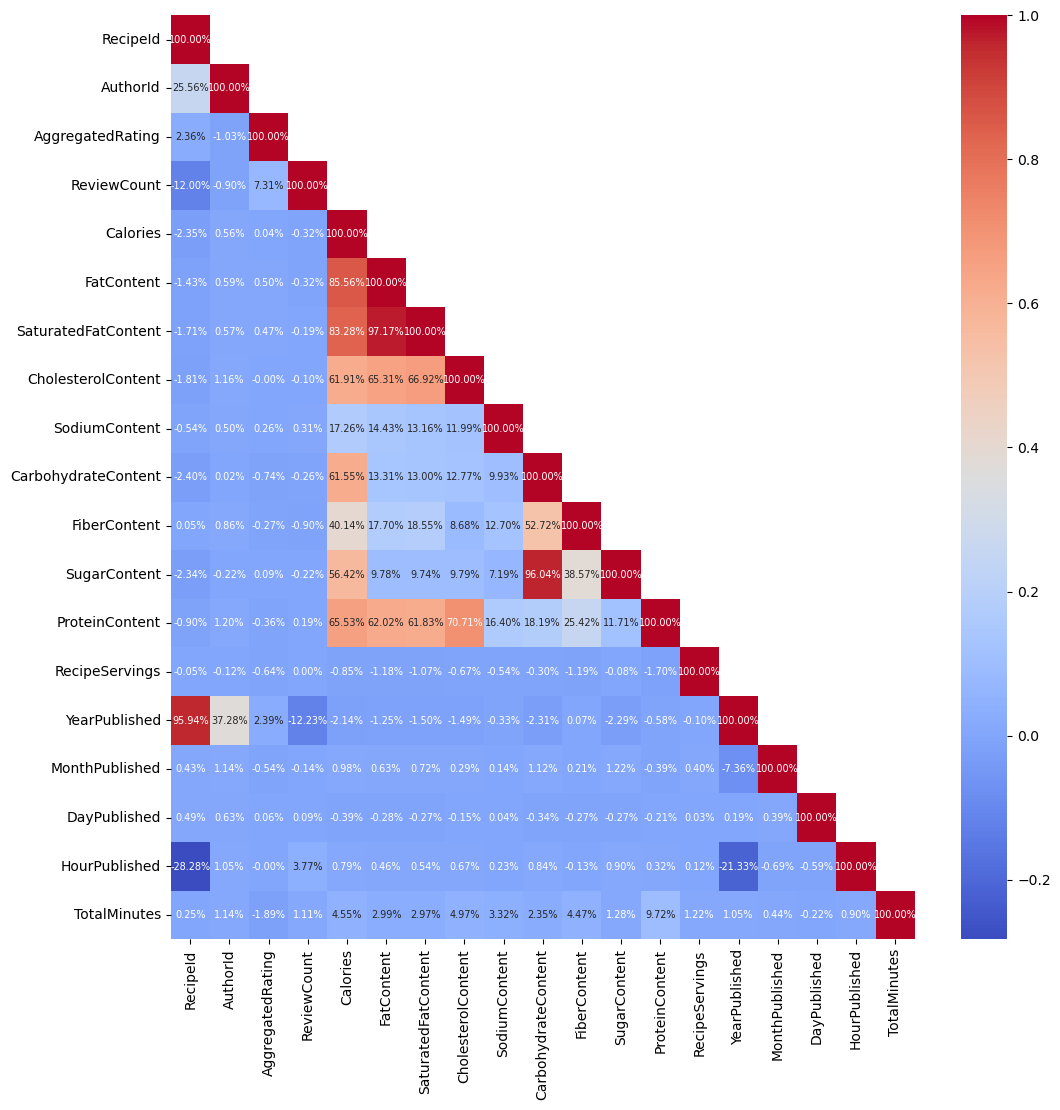

In [146]:
plt.figure(figsize=(12,12))

mask = ~np.tri(corr_matrix.shape[0], k=0, dtype=bool)
sns.heatmap(corr_matrix,cmap='coolwarm',mask=mask,annot=True,fmt=".2%",annot_kws={"fontsize": 7});

In [149]:
recipes['AuthorId'].value_counts()

37779         7742
283251        6375
89831         3926
57042         3435
883095        3399
              ... 
510217           1
824090           1
374882           1
827464           1
2001302649       1
Name: AuthorId, Length: 57178, dtype: int64

In [156]:
recipes.groupby(['YearPublished', 'AuthorId']).count().query('AuthorId == 37779')

,,RecipeId,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,url,MonthPublished,DayPublished,HourPublished,TotalMinutes
YearPublished,AuthorId,,,,,,,,,,,,,,,,,,,,,,,,,,
2002,37779,890,890,890,890,890,890,890,767,770,890,890,890,890,890,890,890,890,890,547,185,890,890,890,890,890,890
2003,37779,608,608,608,608,608,608,608,450,453,608,608,608,608,608,608,608,608,608,495,116,608,608,608,608,608,608
2004,37779,320,320,320,320,320,320,320,216,218,320,320,320,320,320,320,320,320,320,219,76,320,320,320,320,320,320
2005,37779,837,837,837,837,837,837,837,438,449,837,837,837,837,837,837,837,837,837,554,185,837,837,837,837,837,837
2006,37779,809,809,809,808,809,809,809,367,369,809,809,809,809,809,809,809,809,809,570,129,809,809,809,809,809,809
2007,37779,860,860,860,854,860,860,860,272,278,860,860,860,860,860,860,860,860,860,569,198,860,860,860,860,860,860
2008,37779,624,624,624,615,624,624,624,149,154,624,624,624,624,624,624,624,624,624,369,182,624,624,624,624,624,624
2009,37779,348,348,348,345,348,348,348,89,92,348,348,348,348,348,348,348,348,348,197,84,348,348,348,348,348,348
2010,37779,559,559,559,552,559,559,559,95,101,559,559,559,559,559,559,559,559,559,368,106,559,559,559,559,559,559


In [159]:
recipes.groupby(['YearPublished', 'AuthorId']).count().query('AuthorId == 37779').sum()

RecipeId                      7742
Description                   7742
Images                        7742
RecipeCategory                7710
Keywords                      7742
RecipeIngredientQuantities    7742
RecipeIngredientParts         7742
AggregatedRating              3049
ReviewCount                   3098
Calories                      7742
FatContent                    7742
SaturatedFatContent           7742
CholesterolContent            7742
SodiumContent                 7742
CarbohydrateContent           7742
FiberContent                  7742
SugarContent                  7742
ProteinContent                7742
RecipeServings                5465
RecipeYield                   1560
RecipeInstructions            7742
url                           7742
MonthPublished                7742
DayPublished                  7742
HourPublished                 7742
TotalMinutes                  7742
dtype: int64

In [21]:
recipes.isna().sum()

RecipeId                           0
Name                               0
AuthorId                           0
AuthorName                         0
CookTime                       82545
PrepTime                           0
TotalTime                          0
DatePublished                      0
Description                        5
Images                             1
RecipeCategory                   751
Keywords                           0
RecipeIngredientQuantities         0
RecipeIngredientParts              0
AggregatedRating              253223
ReviewCount                   247489
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182911
RecipeYield                   348071
R

In [309]:
pd.DataFrame(recipes.drop(['url','Description'],axis=1).iloc[[3,5]])

,RecipeId,AuthorId,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes
3,41.0,1586,Soy/Tofu,"[Beans, Vegetable, Low Cholesterol, Weeknight,...","[12, 1, 2, 1, 10, 1, 3, 2, 2, 2, 1, 2, 1⁄2, 1⁄...","[extra firm tofu, eggplant, zucchini, mushroom...",4.5,2.0,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"[Drain the tofu, carefully squeezing out exces...",1999,9,3,14,260
5,43.0,34879,Pie,"[Dessert, Weeknight, Stove Top, < 4 Hours]","[1 1⁄4, 1⁄4, 6, 1⁄3, 1⁄4, 1⁄4, 2, 3, 1, 1, 1⁄4...","[graham cracker crumbs, sugar, butter, sugar, ...",1.0,1.0,437.9,19.3,10.9,94.3,267.6,58.0,1.8,42.5,7.0,8.0,1 9-inch pie,"[Graham Cracker Crust: In small bowl, combine ...",1999,8,21,10,140


In [302]:
#pd.DataFrame(recipes.drop(['url','Description'],axis=1).iloc[[3,5]]).to_csv('Data_Wireframe (recipes)- Amirhossein_kiani.csv')

In [308]:
#recipes.duplicated().sum()

In [37]:
recipes['RecipeInstructions']

0         [Toss 2 cups berries with sugar., Let stand fo...
1         [Soak saffron in warm milk for 5 minutes and p...
2         [Into a 1 quart Jar with tight fitting lid, pu...
3         [Drain the tofu, carefully squeezing out exces...
4         [Mix everything together and bring to a boil.,...
                                ...                        
522512    [Preheat oven to 350&deg;F Grease an 8x8 cake ...
522513    [Position rack in center of oven and preheat t...
522514    [heat half and half and heavy cream to a simme...
522515    [In a small bowl, combine mayo and wasabi past...
522516    [Mix sausage, panko, egg yolk and Wocestershir...
Name: RecipeInstructions, Length: 522517, dtype: object

## Topic Modeling of Recipes Using BERTopic applied to `RecipeInstructions` 

Install the required libraries: Make sure you have the necessary libraries installed. You will need transformers, bertopic, and umap-learn. You can install them using pip:

In [38]:
!pip install transformers bertopic umap-learn

  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)
                                              0.0/143.4 kB ? eta -:--:--
     -------------------------------------- 143.4/143.4 kB 8.3 MB/s eta 0:00:00
  Using cached umap-learn-0.5.3.tar.gz (88 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached filelock-3.12.2-py3-none-any.whl (10 kB)
  Using cached huggingface_hub-0.15.1-py3-none-any.whl (236 kB)
  Using cached regex-2023.6.3-cp310-cp310-win_amd64.whl (268 kB)
  Using cached tokenizers-0.13.3-cp310-cp310-win_amd64.whl (3.5 MB)
  Using cached safetensors-0.3.1-cp310-cp310-win_amd64.whl (263 kB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
                                              0.0/595.9 kB ? eta -:--:--
     ------------------------------------- 595.9/595.9 kB 18.9 MB/s eta 0:00:00
  Using cached scikit_learn-1.2.2-cp310-cp310-win_amd64.whl (8.3 MB)
  Using cached sentence_transformers-2.2.2

In [40]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Download stopwords and lemmatizer resources
nltk.download('stopwords')
nltk.download('wordnet')

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [50]:
text = ''
for i in ['A', 'B']:
    text += i+' '
text

'A B '

In [57]:
recipes['RecipeInstructionsTokenized'] = recipes['RecipeInstructions'].apply(lambda x: preprocess_text("".join(x)))

In [63]:
recipes['RecipeInstructionsTokenized'].replace('.', ' ').replace(',',' ')

0         toss 2 cup berry sugar.let stand 45 minute sti...
1         soak saffron warm milk 5 minute puree blender....
2         1 quart jar tight fitting lid put sugar lemon ...
3         drain tofu carefully squeezing excess water pa...
4         mix everything together bring boil.reduce heat...
                                ...                        
522512    preheat oven 350 deg f grease 8x8 cake pan rec...
522513    position rack center oven preheat 450°f place ...
522514    heat half half heavy cream simmer add sugar.re...
522515    small bowl combine mayo wasabi paste stir well...
522516    mix sausage panko egg yolk wocestershire sauce...
Name: RecipeInstructionsTokenized, Length: 522517, dtype: object

In [116]:
all_instructions = recipes['RecipeInstructionsTokenized'][:10000].apply(lambda x: x)
list(all_instructions)

['toss 2 cup berry sugar.let stand 45 minute stirring occasionally.transfer berry-sugar mixture food processor.add yogurt process smooth.strain fine sieve pour baking pan transfer ice cream maker process according manufacturer direction freeze uncovered edge solid centre soft transfer processor blend smooth again.return pan freeze edge solid.transfer processor blend smooth again.fold remaining 2 cup blueberries.pour plastic mold freeze overnight let soften slightly serve',
 'soak saffron warm milk 5 minute puree blender.add chile onion ginger garlic clove peppercorn cardamom seed cinnamon coriander cumin seed poppy seed nutmeg mace cilantro mint leaf lemon juice blend smooth paste put paste large bowl add yogurt mix well.marinate chicken yogurt mixture salt covered least 2 6 hour refrigerator.in skillet heat oil medium heat 1 minute add ghee 15 second later add onion fry about8 minutes.reserve garnish.in skillet cook chicken marinade tomato 10 minute medium heat uncovered.remove chicke

In [117]:
from bertopic import BERTopic

# Assuming you have a DataFrame named 'recipes' with a column 'instructionsTokenized' containing tokenized instructions

# Concatenate all tokenized instructions together
#all_instructions = [token for tokens in recipes['instructionsTokenized'] for token in tokens]

# Initialize BERTopic
topic_model = BERTopic(language='english')

# Apply fit_transform to the combined list of tokenized instructions
topics, _ = topic_model.fit_transform(list(all_instructions))

In [122]:
topics, _ 

([-1,
  -1,
  -1,
  -1,
  -1,
  31,
  8,
  3,
  18,
  7,
  -1,
  8,
  -1,
  -1,
  1,
  -1,
  29,
  59,
  3,
  1,
  -1,
  -1,
  -1,
  -1,
  4,
  57,
  22,
  1,
  29,
  48,
  -1,
  14,
  -1,
  103,
  -1,
  -1,
  82,
  -1,
  4,
  133,
  50,
  12,
  78,
  13,
  -1,
  -1,
  135,
  56,
  69,
  -1,
  -1,
  -1,
  -1,
  -1,
  0,
  48,
  129,
  1,
  90,
  11,
  15,
  -1,
  86,
  19,
  -1,
  50,
  40,
  99,
  -1,
  49,
  16,
  5,
  135,
  -1,
  29,
  1,
  36,
  40,
  -1,
  109,
  34,
  -1,
  5,
  -1,
  -1,
  -1,
  -1,
  -1,
  10,
  40,
  38,
  -1,
  -1,
  -1,
  48,
  -1,
  -1,
  -1,
  0,
  3,
  29,
  18,
  46,
  -1,
  0,
  -1,
  -1,
  71,
  18,
  -1,
  0,
  -1,
  11,
  91,
  48,
  58,
  -1,
  92,
  60,
  92,
  8,
  0,
  -1,
  -1,
  -1,
  58,
  -1,
  -1,
  34,
  -1,
  9,
  -1,
  16,
  -1,
  -1,
  1,
  16,
  -1,
  -1,
  20,
  49,
  -1,
  12,
  135,
  9,
  -1,
  -1,
  -1,
  120,
  6,
  6,
  9,
  19,
  10,
  27,
  -1,
  0,
  88,
  -1,
  -1,
  -1,
  -1,
  2,
  0,
  -1,
  -1,
  2,
  120,
  48,
  132,
 

In [123]:
topic_distributions = topic_model.get_topics()
topic_distributions

{-1: [('chicken', 0.006299779669915109),
  ('heat', 0.00582477217873751),
  ('mixture', 0.005555228435762176),
  ('add', 0.005454778890734049),
  ('minute', 0.005391656128609254),
  ('onion', 0.005208128636622974),
  ('sauce', 0.0049902213444096895),
  ('stir', 0.004979569789661936),
  ('cheese', 0.004922345637042051),
  ('water', 0.004858682894964362)],
 0: [('cookie', 0.03007213774827539),
  ('sheet', 0.020393456569704486),
  ('cooky', 0.01936366203482323),
  ('dough', 0.015719219558645216),
  ('baking', 0.015185284729723436),
  ('flour', 0.013907217166776455),
  ('ungreased', 0.013355751055687752),
  ('sugar', 0.012725175510878987),
  ('apart', 0.01263287376883116),
  ('soda', 0.012471282834565492)],
 1: [('ingredient', 0.05201686700840973),
  ('blender', 0.03221355426266378),
  ('combine', 0.02924512602435862),
  ('mix', 0.026801884227873912),
  ('shake', 0.0221871299673153),
  ('chill', 0.020328064912460714),
  ('blend', 0.01952277990482601),
  ('together', 0.018278035043898005),


In [124]:
topic_labels = list(topic_distributions.keys())
topic_vectors = [list(dict(topic_distributions[topic]).values()) for topic in topic_labels]

In [125]:
topic_labels

[-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142]

In [126]:
topic_vectors

[[0.006299779669915109,
  0.00582477217873751,
  0.005555228435762176,
  0.005454778890734049,
  0.005391656128609254,
  0.005208128636622974,
  0.0049902213444096895,
  0.004979569789661936,
  0.004922345637042051,
  0.004858682894964362],
 [0.03007213774827539,
  0.020393456569704486,
  0.01936366203482323,
  0.015719219558645216,
  0.015185284729723436,
  0.013907217166776455,
  0.013355751055687752,
  0.012725175510878987,
  0.01263287376883116,
  0.012471282834565492],
 [0.05201686700840973,
  0.03221355426266378,
  0.02924512602435862,
  0.026801884227873912,
  0.0221871299673153,
  0.020328064912460714,
  0.01952277990482601,
  0.018278035043898005,
  0.01793240177821806,
  0.01773320529025992],
 [0.028292739083545747,
  0.016284636164608717,
  0.015782860847592273,
  0.013518187398083775,
  0.012945836717043014,
  0.011998644909266333,
  0.011413084110269003,
  0.011207483836138217,
  0.011001762506860418,
  0.010607739438469821],
 [0.04749076391486362,
  0.03330581828317543,
 

In [156]:
umap_embeddings = umap.UMAP(n_neighbors=9, min_dist=0.3, random_state=42).fit_transform(topic_vectors)

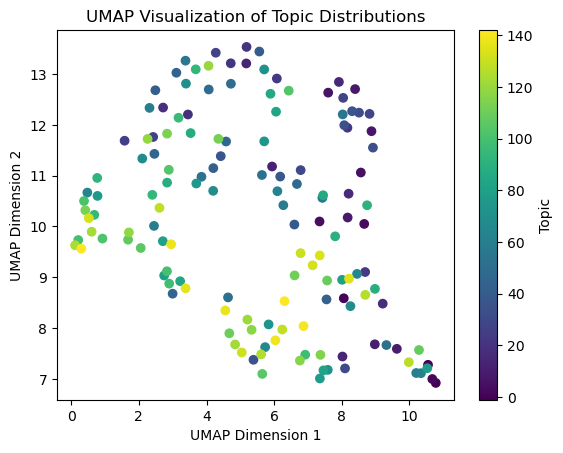

In [157]:
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=topic_labels, cmap='viridis')
plt.colorbar(label='Topic')
plt.title('UMAP Visualization of Topic Distributions')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [158]:
import umap
import plotly.express as px

# Prepare the topic distributions
topic_distributions = topic_model.get_topics()

# Extract the topic distributions and their corresponding labels
topic_labels = list(topic_distributions.keys())
topic_vectors = [list(dict(topic_distributions[topic]).values()) for topic in topic_labels]

# Apply UMAP to reduce the dimensionality of the topic vectors
umap_embeddings = umap.UMAP(n_neighbors=9, min_dist=0.3, random_state=42).fit_transform(topic_vectors)

# Create an interactive scatter plot using plotly
fig = px.scatter(umap_embeddings, x=0, y=1, color=topic_labels, labels={'color': 'Topic'})
fig.update_layout(title='UMAP Visualization of Topic Distributions')
fig.show()


In [151]:
topic_distributions[95]

[('lentil', 0.17925827866227373),
 ('soup', 0.029954537184483182),
 ('bulghur', 0.022182746555363297),
 ('tender', 0.02045497631691721),
 ('simmer', 0.019372752026352115),
 ('liquid', 0.01782992938030996),
 ('reduce', 0.017644065647259042),
 ('bay', 0.017349823254065085),
 ('pasta', 0.015905855866173046),
 ('wheat', 0.015161908804339359)]

In [137]:
topic_distributions[64]

[('rib', 0.17857025434404372),
 ('barbecue', 0.02558277518926044),
 ('short', 0.023462196827963612),
 ('basting', 0.01863791497305453),
 ('coal', 0.01833332157811151),
 ('sauce', 0.018003818128632634),
 ('hour', 0.016775333477360873),
 ('ribscover', 0.01293703026191982),
 ('ribsplace', 0.01293703026191982),
 ('turning', 0.012413836218160732)]

In [94]:
import umap.umap_ as umap
import numpy as np

# Assuming you have the 'all_instructions' list containing preprocessed recipe instructions

# Obtain BERTopic embeddings for the preprocessed instructions
embeddings = topic_model.transform(all_instructions)

# Check if the embeddings list is empty or contains any zero-size arrays
if len(embeddings) == 0 or any(len(embedding) == 0 for embedding in embeddings):
    print("No valid data found. Check your preprocessing steps.")
else:
    # Print the shapes and values of embeddings for debugging
    print("Embeddings shape:", np.array(embeddings).shape)
    print("Embeddings values:", embeddings)
    
    # Apply UMAP dimensionality reduction
    umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2).fit_transform(embeddings)
    
    # Continue with further analysis or visualization
    topic_model.visualize_umap(umap_embeddings)

Embeddings shape: (2, 1000)
Embeddings values: ([-1, -1, 4, -1, -1, 1, 8, -1, 16, -1, -1, 8, 0, -1, -1, 0, 0, 9, 1, -1, 6, 13, -1, 0, 9, 6, 10, -1, 0, 13, -1, 10, 3, -1, 21, -1, 9, -1, 9, 6, 1, -1, 19, 15, -1, 0, 0, 0, -1, 0, 4, 8, 4, -1, 0, 13, -1, -1, -1, 2, 12, -1, -1, 18, 6, 1, -1, -1, -1, 0, 3, -1, 0, -1, 0, -1, 0, -1, 0, -1, -1, 2, -1, -1, 11, -1, 17, 0, 4, -1, -1, 0, -1, -1, 13, 0, 2, -1, 0, -1, 0, 16, 13, 3, 0, 0, 10, 0, 16, 2, -1, 8, 2, 20, 13, -1, -1, 8, 19, 8, 8, 0, 9, -1, -1, -1, 3, 8, -1, 0, -1, -1, -1, 0, 3, -1, 8, 10, -1, 6, 0, 6, -1, 0, 7, -1, -1, -1, -1, 21, 6, 7, 18, 2, 21, 2, 0, 17, 13, -1, -1, -1, 5, 0, -1, -1, -1, 5, 13, 0, 10, 0, -1, 1, 5, 0, 0, 5, 5, 5, 0, -1, 1, -1, -1, 5, 3, 2, -1, -1, -1, 19, 19, -1, 9, -1, -1, 7, 9, 16, 0, 1, 19, 0, -1, 19, 19, 19, 4, -1, 17, 12, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 15, 1, 2, 18, -1, 6, -1, 0, -1, -1, 2, 14, 2, 16, -1, 16, 19, -1, 2, -1, 4, 12, 5, -1, 5, -1, 0, -1, 17, 0, 5, 9, 4, 2, 0, 1, -1, 3, 3, 3, 7, 14, 14, 7, -1,

ValueError: zero-size array to reduction operation maximum which has no identity

## Reviews <a class ='author' id='rev'></a>

In [278]:
reviews = pd.read_parquet('reviews.parquet')

In [279]:
reviews.sample(5)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
529508,575349,15878,209743,Im_Genia,5,I had this dish as a side with Australian Meat...,2008-02-07 20:57:41+00:00,2008-02-07 20:57:41+00:00
774401,858043,271057,424680,Sydney Mike,5,"Even though I cut the recipe in half, omitted ...",2009-04-28 10:13:31+00:00,2009-04-28 10:13:31+00:00
1043522,1195023,187793,1803245,ken barbie,0,"These are good, but my guests were flush in th...",2011-02-24 17:47:48+00:00,2011-02-24 17:47:48+00:00
242945,260278,159558,246616,CaraLynnie,5,So fast and easy and very tasty,2006-03-27 11:41:20+00:00,2006-03-27 11:41:20+00:00
98909,107015,91778,117438,Sassy Syrah,0,I cannot in all conscience give this a star ra...,2004-06-08 01:11:26+00:00,2004-06-08 01:11:26+00:00


In [281]:
reviews.isna().sum()

ReviewId         0
RecipeId         0
AuthorId         0
AuthorName       0
Rating           0
Review           0
DateSubmitted    0
DateModified     0
dtype: int64

In [282]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   ReviewId       1401982 non-null  int32              
 1   RecipeId       1401982 non-null  int32              
 2   AuthorId       1401982 non-null  int32              
 3   AuthorName     1401982 non-null  object             
 4   Rating         1401982 non-null  int32              
 5   Review         1401982 non-null  object             
 6   DateSubmitted  1401982 non-null  datetime64[ns, UTC]
 7   DateModified   1401982 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int32(4), object(2)
memory usage: 64.2+ MB


In [283]:
reviews.groupby('RecipeId').count()

,ReviewId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
RecipeId,,,,,,,
38,4,4,4,4,4,4,4
39,1,1,1,1,1,1,1
40,9,9,9,9,9,9,9
41,2,2,2,2,2,2,2
42,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...
540899,1,1,1,1,1,1,1
541001,1,1,1,1,1,1,1
541030,1,1,1,1,1,1,1


In [286]:
reviews['RecipeId'].sort_values(ascending=False)

1401102    541298
1400522    541195
1399916    541030
1399466    541001
1398924    540899
            ...  
338746         39
716354         38
1263786        38
532978         38
1261835        38
Name: RecipeId, Length: 1401982, dtype: int32

In [287]:
reviews.sample(5)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
652570,715749,321477,160977,Chef Dudo,3,"It was OK, we liked it but it was not special....",2008-09-28 11:09:56+00:00,2008-09-28 11:09:56+00:00
348772,372537,189787,242161,Whats Cooking,5,This was really quite tasty! I used just one l...,2007-02-13 12:58:18+00:00,2007-02-13 12:58:18+00:00
166188,178050,27294,93006,LorenLou,4,"These were quite tasty, but believe it or not,...",2005-05-31 17:34:13+00:00,2005-05-31 17:34:13+00:00
664872,729932,127331,115088,quikgourmet,5,Fantastic fresh veggie dish! Loved the taste ...,2008-10-19 23:17:48+00:00,2008-10-19 23:17:48+00:00
927144,1060868,248581,68526,Lindas Busy Kitchen,5,My friend and I had this for dinner with baked...,2010-02-27 20:54:07+00:00,2010-02-27 20:54:07+00:00


In [294]:
(reviews['ReviewId'].value_counts() > 1).sum()

0

In [296]:
reviews['YearSubmitted'] = reviews['DateSubmitted'].apply(lambda date: date.year)
reviews['MonthSubmitted'] = reviews['DateSubmitted'].apply(lambda date: date.month)
reviews['DaySubmitted'] = reviews['DateSubmitted'].apply(lambda date: date.day)
reviews['HourSubmitted'] = reviews['DateSubmitted'].apply(lambda date: date.hour)

In [300]:
reviews.drop(['AuthorName', 'DateSubmitted', 'DateModified'],axis=1,inplace=True)

In [303]:
reviews.sample(2).to_csv('Data_Wireframe (reviews)- Amirhossein_kiani.csv')

In [306]:
reviews.duplicated().sum()

0